# 2.2.0 Creating MDS Plots for PredNet

Creating MDS (or some other dim redux) plots on the nodes 

## Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [1]:
# Load `watermark` extension
%load_ext watermark
# Display the status of the machine and other non-code related info
%watermark -n -m -g -b -t -h

Mon Sep 07 2020 16:11:30 

compiler   : GCC 7.3.0
system     : Linux
release    : 5.4.0-45-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
host name  : apra-x3
Git hash   : 936d447b6a441eeaee74e5fb7cafb9a1caca453d
Git branch : master


Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [2]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [3]:
# Set the matplotlib mode
%matplotlib inline

## Imports

In [4]:
import gc
import logging
from argparse import Namespace
from pathlib import Path

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from PIL import Image, ImageOps
from torch.utils.data import IterableDataset, DataLoader

%aimport prevseg.constants
import prevseg.constants as const
%aimport prevseg.index
import prevseg.index as index
%aimport prevseg.datasets.schapiro
import prevseg.datasets.schapiro as sch
%aimport prevseg.schapiro
from prevseg.schapiro import walk, graph
%aimport prevseg.models.prednet
import prevseg.models.prednet as prednet

# Keep track of versions of everything
%watermark -v -iv

PIL.Image         7.2.0
numpy             1.19.1
networkx          2.4
logging           0.5.1.2
torch             1.6.0
pytorch_lightning 0.8.5
prevseg           0+untagged.81.g936d447.dirty
CPython 3.8.5
IPython 7.16.1


## Returning the Labels (Graph Path)

Realized it would be useful to have the graph position at each step, so modifying the dataset to return that as well.

In [5]:
max_steps = 2
epochs = 2
batch_size = 2
n_paths = 2

iter_ds = sch.ShapiroFractalsDataset(
    batch_size=batch_size, 
    max_steps=max_steps,
    n_paths=n_paths)
loader = DataLoader(iter_ds, batch_size=None)
for _ in range(epochs):
    for i, batch in enumerate(loader):
        print(i, batch[0].shape)
        if i == n_paths:
            print('bad')
            break

Created mapping as follows:
{0: '77', 1: '93', 2: '25', 3: '53', 4: '98', 5: '80', 6: '54', 7: '28', 8: '100', 9: '6', 10: '64', 11: '46', 12: '94', 13: '78', 14: '84'}
0 torch.Size([2, 2, 128, 128])
1 torch.Size([2, 2, 128, 128])
0 torch.Size([2, 2, 128, 128])
1 torch.Size([2, 2, 128, 128])


In [6]:
class ShapiroFractalsDataset(IterableDataset):
    modes = set(('random', 'euclidean', 'hamiltonian'))
    def __init__(self, batch_size=32, n_pentagons=3, max_steps=128, n_paths=128, mapping=None, 
                 mode='random'):
        self.batch_size = batch_size
        self.n_pentagons = n_pentagons
        self.max_steps = max_steps
        self.n_paths = n_paths
        self.mapping = mapping
        self.mode = mode
        assert self.mode in self.modes
        
        self.G = graph.schapiro_graph(n_pentagons=n_pentagons)
        
        self.load_node_stimuli()
        
        self.mapping = {node : path.stem
                        for node, path in zip(range(len(self.G.nodes)),
                                              self.paths_data)}
        print(f'Created mapping as follows:\n{self.mapping}')    
        
    def load_node_stimuli(self):
        # Load the fractal images into memory
        assert index.DIR_SCH_FRACTALS.exists()
        if self.mapping:
            self.paths_data = [index.DIR_SCH_FRACTALS / (name+'.tiff')
                               for name in self.mapping.values()]
        else:
            paths_data = list(index.DIR_SCH_FRACTALS.iterdir())
            np.random.shuffle(paths_data)
            self.paths_data = paths_data[:5*self.n_pentagons]
        self.array_data = np.array(
            [np.array(ImageOps.grayscale(Image.open(str(path))))
             for path in self.paths_data])
        
    def iter_single_sample(self): 
        if self.mode == 'random':
            iter_walk = walk.walk_random(self.G, steps=self.max_steps)
        elif self.mode == 'euclidean':
            iter_walk = walk.walk_euclidean(self.G)
        elif self.mode == 'hamiltonian':
            iter_walk = walk.walk_hamiltonian(self.G)
        
        for sample in iter_walk:
            yield self.array_data[sample[0]], sample[0]
        
    def iter_batch_sample(self):
        iter_batch = zip(*[self.iter_single_sample() for _ in range(self.batch_size)])
        for batch in iter_batch:
            data, nodes = zip(*batch)
            yield data, nodes
        
    def iter_batch_dataset(self):   
        for _ in range(self.n_paths):
            data, nodes = zip(*list(self.iter_batch_sample()))
            yield np.moveaxis(np.array(data), 0, 1), nodes
        
    def __iter__(self):
        return self.iter_batch_dataset()

    
max_steps = 5
epochs = 2
batch_size = 2
n_paths = 3

iter_ds = ShapiroFractalsDataset(batch_size=batch_size, max_steps=max_steps, n_paths=n_paths)
loader = DataLoader(iter_ds, batch_size=None)
for _ in range(epochs):
    for i, batch in enumerate(loader):
        print(i, batch[0].shape, batch[1])
        if i == n_paths:
            print('bad')
            break
            
mapping = iter_ds.mapping

Created mapping as follows:
{0: '70', 1: '47', 2: '31', 3: '89', 4: '94', 5: '87', 6: '98', 7: '7', 8: '78', 9: '74', 10: '79', 11: '75', 12: '95', 13: '101', 14: '35'}
0 torch.Size([2, 5, 128, 128]) [[7, 13], [5, 11], [6, 13], [9, 11], [8, 10]]
1 torch.Size([2, 5, 128, 128]) [[5, 2], [7, 4], [8, 3], [7, 0], [5, 3]]
2 torch.Size([2, 5, 128, 128]) [[11, 2], [14, 4], [11, 5], [13, 8], [14, 9]]
0 torch.Size([2, 5, 128, 128]) [[11, 6], [10, 9], [12, 7], [14, 5], [12, 8]]
1 torch.Size([2, 5, 128, 128]) [[9, 10], [7, 13], [9, 11], [6, 10], [8, 11]]
2 torch.Size([2, 5, 128, 128]) [[10, 10], [12, 9], [10, 8], [12, 6], [14, 7]]


In [7]:
max_steps = 5
epochs = 2
batch_size = 3
n_paths = 2

class ShapiroResnetEmbeddingDataset(ShapiroFractalsDataset):
    def load_node_stimuli(self):
        # Load the fractal images into memory
        assert index.DIR_SCH_FRACTALS.exists()
        if self.mapping:
            self.paths_data = [index.DIR_SCH_FRACTALS_EMB / (name+'.npy')
                               for name in self.mapping.values()]
        else:
            paths_data = list(index.DIR_SCH_FRACTALS_EMB.iterdir())
            np.random.shuffle(paths_data)
            self.paths_data = paths_data[:5*self.n_pentagons]
        self.array_data = np.array(
            [np.array(np.load(str(path)))
             for path in self.paths_data])    

iter_ds = ShapiroResnetEmbeddingDataset(
    batch_size=batch_size, 
    max_steps=max_steps, 
    n_paths=n_paths,
    mapping=mapping,
)
loader = DataLoader(iter_ds, batch_size=None)

for _ in range(epochs):
    for i, batch in enumerate(loader):
        print(i, batch[0].shape, batch[1])
        if i == n_paths:
            print('bad')
            break

Created mapping as follows:
{0: '70', 1: '47', 2: '31', 3: '89', 4: '94', 5: '87', 6: '98', 7: '7', 8: '78', 9: '74', 10: '79', 11: '75', 12: '95', 13: '101', 14: '35'}
0 torch.Size([3, 5, 2048]) [[7, 2, 4], [6, 1, 2], [9, 3, 1], [7, 1, 4], [6, 3, 2]]
1 torch.Size([3, 5, 2048]) [[5, 1, 7], [7, 2, 5], [5, 3, 6], [7, 1, 5], [8, 3, 8]]
0 torch.Size([3, 5, 2048]) [[9, 9, 10], [8, 8, 9], [9, 6, 10], [8, 8, 11], [7, 7, 13]]
1 torch.Size([3, 5, 2048]) [[8, 14, 13], [7, 0, 11], [5, 14, 14], [8, 12, 12], [7, 11, 14]]


## Redefining PredNet Class

In [8]:
class PredCellTracked(prednet.PredCellTracked):
    name = 'predcell'

class PredNetTracked(prednet.PredNetTracked):
    def __init__(self, CellClass=PredCellTracked, *args, **kwargs):
        super().__init__(CellClass=CellC)
    
    def prepare_data(self):
        self.ds = self.ds or ShapiroResnetEmbeddingDataset(
            batch_size=self.batch_size, 
            n_pentagons=self.hparams.n_pentagons, 
            max_steps=self.hparams.max_steps, 
            n_paths=self.hparams.n_paths)
        self.ds_val = ShapiroResnetEmbeddingDataset(
            batch_size=self.batch_size, 
            n_pentagons=self.hparams.n_pentagons,
            n_paths=1,
            mapping=self.ds.mapping,
            mode='euclidean')
        
#         n_test, n_val = self.hparams.n_test, self.hparams.n_val
        
    def train_dataloader(self):
        return DataLoader(self.ds, 
                          batch_size=None,
                          num_workers=self.hparams.n_workers)
    
    def val_dataloader(self):
        return DataLoader(self.ds_val, 
                          batch_size=None,
                          num_workers=self.hparams.n_workers)

## Loading Saved Weights

In [9]:
model, trainer = None, None
train_dataloader, val_dataloader = None, None
errors, optimizer = None, None
ckpt = None
train_errors, val_errors = None, None
res = None
gc.collect()
torch.cuda.empty_cache()

model = PredNetTracked.load_from_checkpoint(str(
    index.DIR_CHECKPOINTS / 
    'prednet_tracked_schapiro_test_v46/schapiro_test_global_step=00127_epoch=003_val_loss=0.106.ckpt'),
)
model.prepare_data()
model.cuda()
hparams = model.hparams

log_dir = Path(hparams.dir_logs) / f'{hparams.name}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)
logger = pl.loggers.TensorBoardLogger(str(log_dir.parent), 
                                      name=hparams.name,
                                      version=0)
model.logger = logger

/home/apra/miniconda3/envs/g2/lib/python3.8/site-packages/torch/cuda/__init__.py:102: UserWarning: 
    Found GPU1 GeForce GTX 670 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))
/home/apra/miniconda3/envs/g2/lib/python3.8/site-packages/torch/cuda/__init__.py:125: UserWarning: 
GeForce GTX 670 with CUDA capability sm_30 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the GeForce GTX 670 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


Created mapping as follows:
{0: '1', 1: '60', 2: '95', 3: '100', 4: '14', 5: '2', 6: '63', 7: '58', 8: '96', 9: '55', 10: '99', 11: '50', 12: '7', 13: '89', 14: '12'}
Created mapping as follows:
{0: '1', 1: '60', 2: '95', 3: '100', 4: '14', 5: '2', 6: '63', 7: '58', 8: '96', 9: '55', 10: '99', 11: '50', 12: '7', 13: '89', 14: '12'}


In [10]:
iter_ds = ShapiroResnetEmbeddingDataset(
    batch_size=1, 
    max_steps=hparams.max_steps, 
    n_paths=1,
    mapping=model.ds.mapping,
    mode='euclidean')
loader = DataLoader(iter_ds, batch_size=None)

for data, nodes in loader:
    pass

Created mapping as follows:
{0: '1', 1: '60', 2: '95', 3: '100', 4: '14', 5: '2', 6: '63', 7: '58', 8: '96', 9: '55', 10: '99', 11: '50', 12: '7', 13: '89', 14: '12'}


In [11]:
data.shape

torch.Size([1, 30, 2048])

In [12]:
data_all = torch.cat((data, torch.flip(data, (0,1))[:,1:,:]), 1)
data_all.shape

torch.Size([1, 59, 2048])

In [13]:
data_all[0,28,0]

tensor(0.0314)

In [14]:
data_all[0,29,0]

tensor(0.1979)

In [15]:
data_all[0,30,0]

tensor(0.0314)

In [16]:
outs = model.forward(data_all, output_mode='eval', run_num='fwd_rev', 
                     tb_labels=['nodes'])

In [17]:
nodes = np.array(nodes).reshape(30)
nodes

array([11, 13, 14, 12, 13, 10, 12, 11, 14,  0,  3,  4,  2,  3,  1,  2,  0,
        1,  4,  5,  8,  9,  7,  8,  6,  7,  5,  6,  9, 10])

In [18]:
nodes_all = np.concatenate((nodes, np.flip(nodes)[1:]))
nodes_all.shape

(59,)

In [19]:
for i, val in enumerate(nodes_all):
    print(i, val)

0 11
1 13
2 14
3 12
4 13
5 10
6 12
7 11
8 14
9 0
10 3
11 4
12 2
13 3
14 1
15 2
16 0
17 1
18 4
19 5
20 8
21 9
22 7
23 8
24 6
25 7
26 5
27 6
28 9
29 10
30 9
31 6
32 5
33 7
34 6
35 8
36 7
37 9
38 8
39 5
40 4
41 1
42 0
43 2
44 1
45 3
46 2
47 4
48 3
49 0
50 14
51 11
52 12
53 10
54 13
55 12
56 14
57 13
58 11


In [20]:
borders = [9, 19, 29, 30, 40, 50]

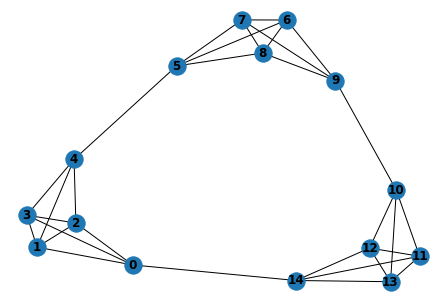

In [21]:
G = graph.schapiro_graph(n_pentagons=3)
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

### Prediction Errors

In [22]:
outs_pe = model.forward(data_all, output_mode='error', run_num='fwd_rev', 
                        tb_labels=['nodes'])

In [23]:
outs_pe.shape

torch.Size([1, 2, 59])

In [24]:
outs_array = outs_pe[0,:,:].cpu().detach().numpy()
outs_array.shape

(2, 59)

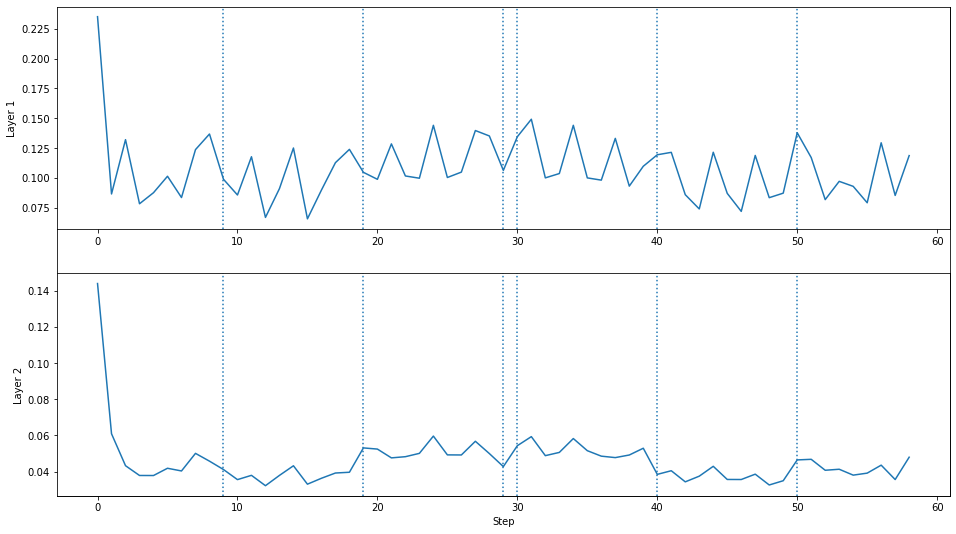

In [25]:
fig = plt.figure()
ax_large = fig.add_subplot(111)

for i, out in enumerate(outs_array):
    ax = fig.add_subplot(11 + i + len(outs_array)*100)
    ax.plot(out)
    ax.set_ylabel(f'Layer {i+1}')
    [ax.axes.axvline(b, ls=':') for b in borders]
    if i == len(outs_array)-1:
        ax.set_xlabel('Step')
        
ax_large.axes.xaxis.set_ticks([])
ax_large.axes.yaxis.set_ticks([])
gcf = plt.gcf()
gcf.set_size_inches(16,9)

### Prediction Error Differences

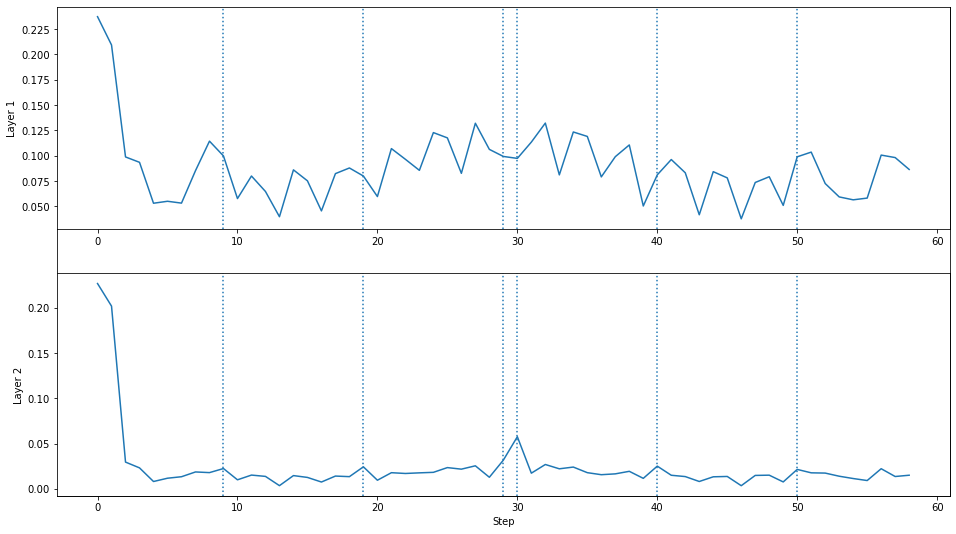

In [26]:
fig = plt.figure()
ax_large = fig.add_subplot(111)

for i, out in enumerate(outs['error_diff']):
    ax = fig.add_subplot(11 + i + len(outs['error_diff'])*100)
    ax.plot(np.array(out.cpu()).reshape(59))
    ax.set_ylabel(f'Layer {i+1}')
    [ax.axes.axvline(b, ls=':') for b in borders]
    if i == len(outs['error_diff'])-1:
        ax.set_xlabel('Step')
        
ax_large.axes.xaxis.set_ticks([])
ax_large.axes.yaxis.set_ticks([])
gcf = plt.gcf()
gcf.set_size_inches(16,9)

### Hidden State Differences

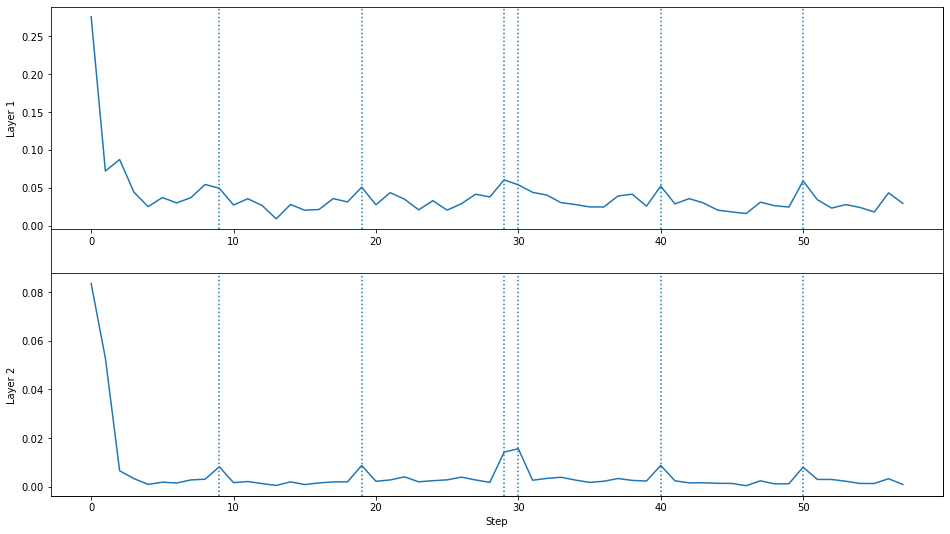

In [27]:
fig = plt.figure()
ax_large = fig.add_subplot(111)

for i, out in enumerate(outs['hidden_diff']):
    ax = fig.add_subplot(11 + i + len(outs['hidden_diff'])*100)
    ax.plot(np.array(out.cpu()).reshape(59)[1:])
    ax.set_ylabel(f'Layer {i+1}')
    [ax.axes.axvline(b, ls=':') for b in borders]
    if i == len(outs['hidden_diff'])-1:
        ax.set_xlabel('Step')
        
ax_large.axes.xaxis.set_ticks([])
ax_large.axes.yaxis.set_ticks([])
gcf = plt.gcf()
gcf.set_size_inches(16,9)

### Representation Differences

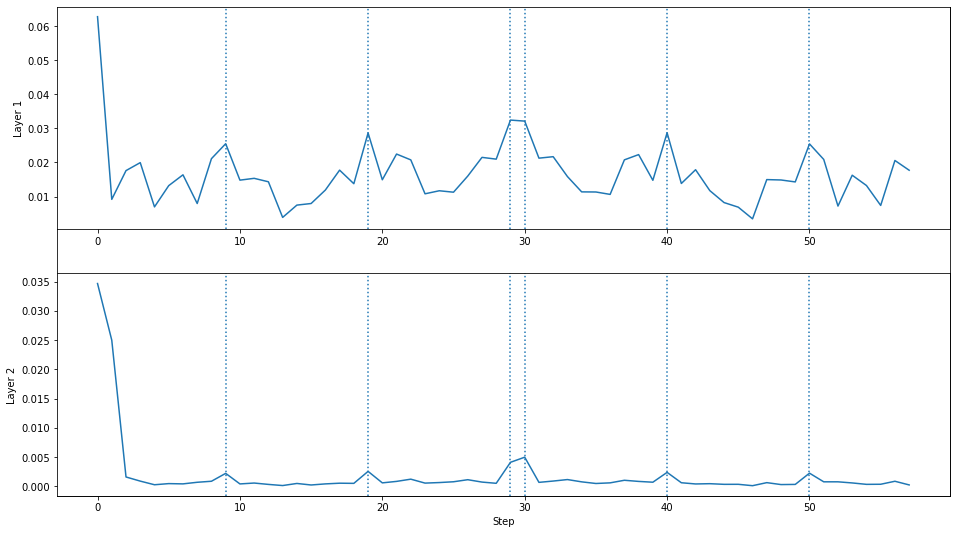

In [28]:
fig = plt.figure()
ax_large = fig.add_subplot(111)

for i, out in enumerate(outs['representation_diff']):
    ax = fig.add_subplot(11 + i + len(outs['representation_diff'])*100)
    ax.plot(np.array(out.cpu()).reshape(59)[1:])
    ax.set_ylabel(f'Layer {i+1}')
    [ax.axes.axvline(b, ls=':') for b in borders]
    if i == len(outs['representation_diff'])-1:
        ax.set_xlabel('Step')
        
ax_large.axes.xaxis.set_ticks([])
ax_large.axes.yaxis.set_ticks([])
gcf = plt.gcf()
gcf.set_size_inches(16,9)

### Alternating Within vs Between Communities

In [29]:
test_nodes = [6,8,9,
              10,9,10,
              13,12,14,
              0,14,0,
              1,2,4,
              5,4,5]
test_data = np.array([iter_ds.array_data[n] 
                      for n in test_nodes]).reshape((1,len(test_nodes),2048))

In [30]:
border_outs = model.forward(torch.Tensor(test_data), 
                            output_mode='eval', 
                            run_num='border_walk_3', 
                            tb_labels=['nodes'])
border_outs_pe = model.forward(data_all, 
                               output_mode='error', 
                               run_num='border_walk_3', 
                               tb_labels=['nodes'])

In [31]:
outs_array = border_outs_pe[0,:,:].cpu().detach().numpy()

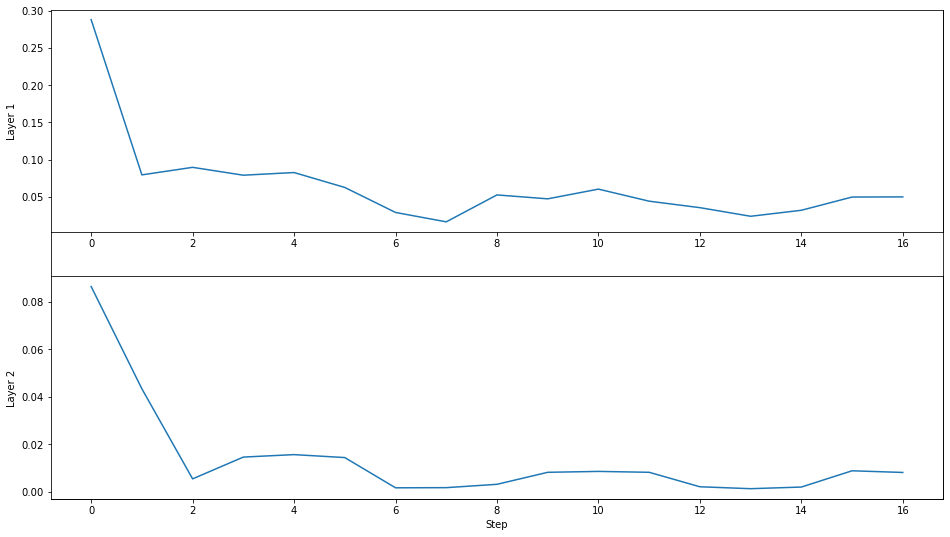

In [32]:
fig = plt.figure()
ax_large = fig.add_subplot(111)

for i, out in enumerate(border_outs['hidden_diff']):
    ax = fig.add_subplot(11 + i + len(border_outs['hidden_diff'])*100)
    ax.plot(np.array(out.cpu()).reshape(len(test_nodes))[1:])
    ax.set_ylabel(f'Layer {i+1}')
    if i == len(border_outs['hidden_diff'])-1:
        ax.set_xlabel('Step')
        
ax_large.axes.xaxis.set_ticks([])
ax_large.axes.yaxis.set_ticks([])
gcf = plt.gcf()
gcf.set_size_inches(16,9)

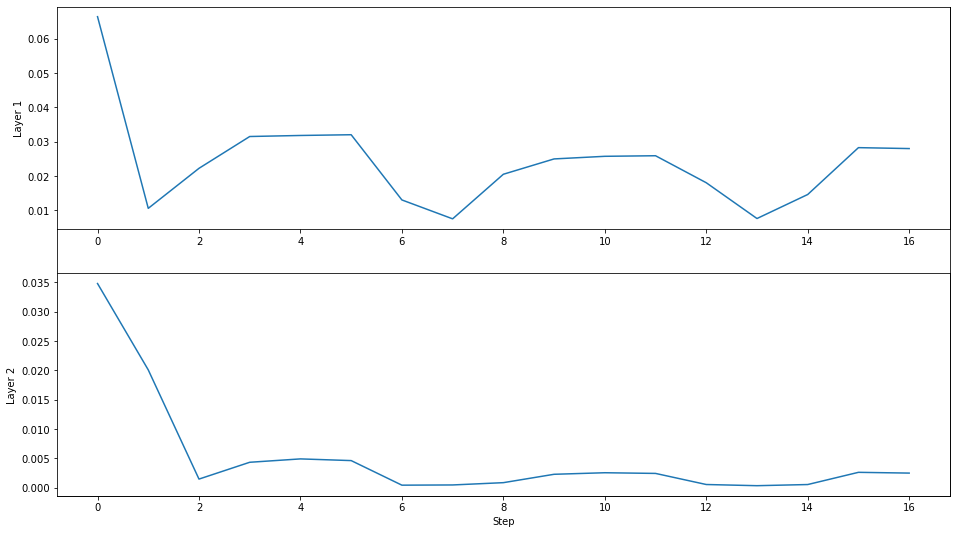

In [33]:
fig = plt.figure()
ax_large = fig.add_subplot(111)

for i, out in enumerate(border_outs['representation_diff']):
    ax = fig.add_subplot(11 + i + len(border_outs['representation_diff'])*100)
    ax.plot(np.array(out.cpu()).reshape(len(test_nodes))[1:])
    ax.set_ylabel(f'Layer {i+1}')
    if i == len(border_outs['representation_diff'])-1:
        ax.set_xlabel('Step')
        
ax_large.axes.xaxis.set_ticks([])
ax_large.axes.yaxis.set_ticks([])
gcf = plt.gcf()
gcf.set_size_inches(16,9)

## Hierarchical PredNet

In [34]:
model, trainer = None, None
train_dataloader, val_dataloader = None, None
errors, optimizer = None, None
ckpt = None
train_errors, val_errors = None, None
res = None
gc.collect()
torch.cuda.empty_cache()

model = PredNetTracked.load_from_checkpoint(str(
    index.DIR_CHECKPOINTS / 
    'prednet_tracked_schapiro_test_v52/schapiro_test_global_step=00255_epoch=007_val_loss=0.106.ckpt'),
)
model.prepare_data()
model.cuda()
hparams = model.hparams

log_dir = Path(hparams.dir_logs) / f'{hparams.name}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)
logger = pl.loggers.TensorBoardLogger(str(log_dir.parent), 
                                      name=hparams.name,
                                      version=0)
model.logger = logger

Created mapping as follows:
{0: '1', 1: '60', 2: '95', 3: '100', 4: '14', 5: '2', 6: '63', 7: '58', 8: '96', 9: '55', 10: '99', 11: '50', 12: '7', 13: '89', 14: '12'}
Created mapping as follows:
{0: '1', 1: '60', 2: '95', 3: '100', 4: '14', 5: '2', 6: '63', 7: '58', 8: '96', 9: '55', 10: '99', 11: '50', 12: '7', 13: '89', 14: '12'}


In [35]:
outs = model.forward(data_all, output_mode='eval', run_num='fwd_rev', 
                     tb_labels=['nodes'])

In [36]:
nodes = np.array(nodes).reshape(30)
nodes

array([11, 13, 14, 12, 13, 10, 12, 11, 14,  0,  3,  4,  2,  3,  1,  2,  0,
        1,  4,  5,  8,  9,  7,  8,  6,  7,  5,  6,  9, 10])

In [37]:
nodes_all = np.concatenate((nodes, np.flip(nodes)[1:]))
nodes_all.shape

(59,)

### Hierarchical Prediction Errors

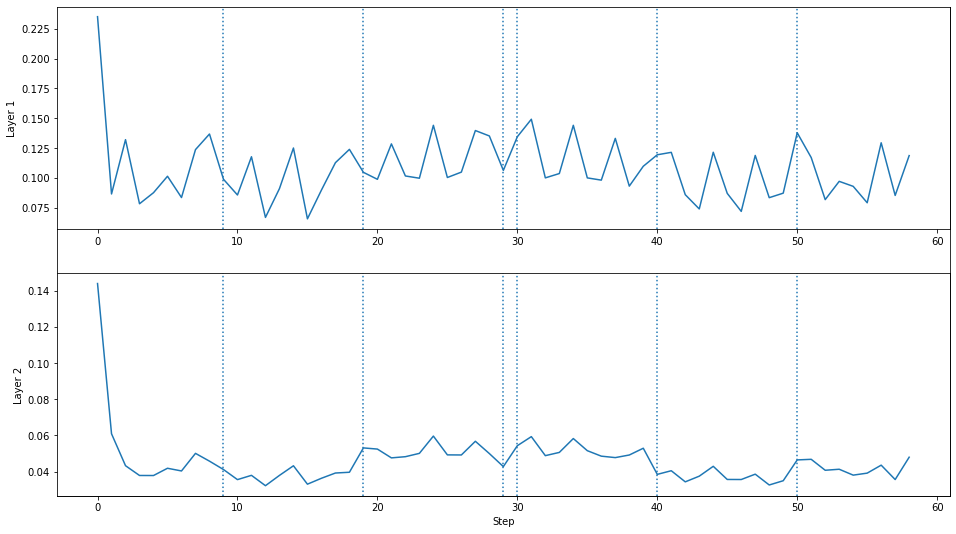

In [38]:
fig = plt.figure()
ax_large = fig.add_subplot(111)

for i, out in enumerate(outs_array):
    ax = fig.add_subplot(11 + i + len(outs_array)*100)
    ax.plot(out)
    ax.set_ylabel(f'Layer {i+1}')
    [ax.axes.axvline(b, ls=':') for b in borders]
    if i == len(outs_array)-1:
        ax.set_xlabel('Step')
        
ax_large.axes.xaxis.set_ticks([])
ax_large.axes.yaxis.set_ticks([])
gcf = plt.gcf()
gcf.set_size_inches(16,9)

### Hierarchical Prediction Error Differences

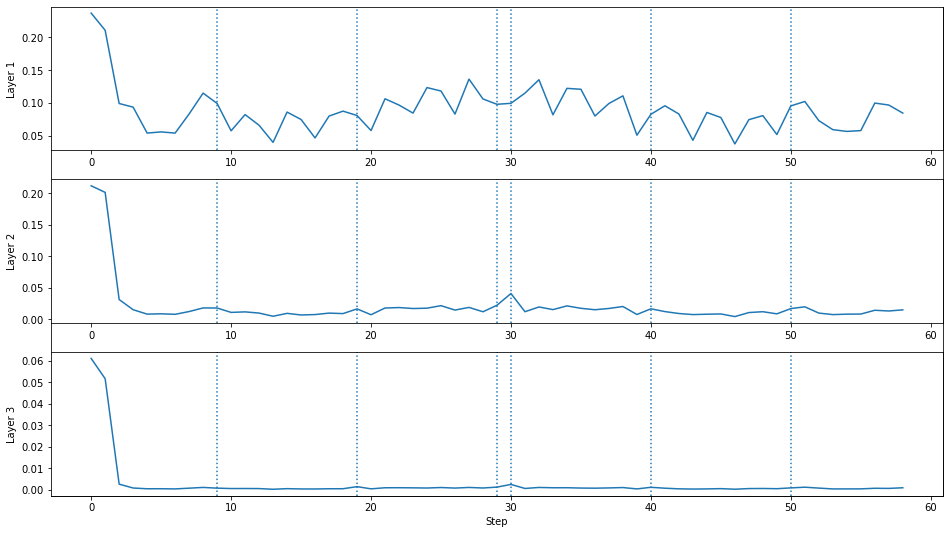

In [39]:
fig = plt.figure()
ax_large = fig.add_subplot(111)

for i, out in enumerate(outs['error_diff']):
    ax = fig.add_subplot(11 + i + len(outs['error_diff'])*100)
    ax.plot(np.array(out.cpu()).reshape(59))
    ax.set_ylabel(f'Layer {i+1}')
    [ax.axes.axvline(b, ls=':') for b in borders]
    if i == len(outs['error_diff'])-1:
        ax.set_xlabel('Step')
        
ax_large.axes.xaxis.set_ticks([])
ax_large.axes.yaxis.set_ticks([])
gcf = plt.gcf()
gcf.set_size_inches(16,9)

### Hierarchical Hidden Differences

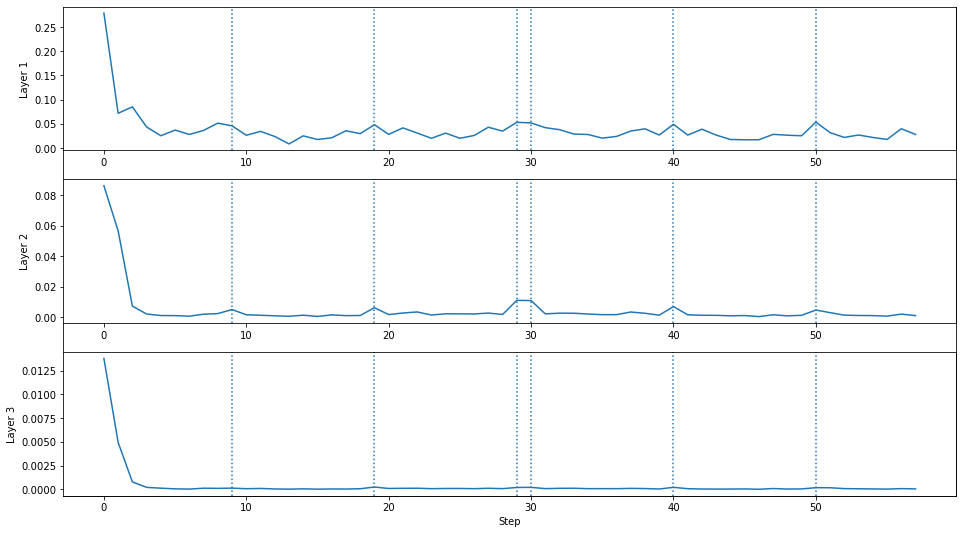

In [40]:
fig = plt.figure()
ax_large = fig.add_subplot(111)

for i, out in enumerate(outs['hidden_diff']):
    ax = fig.add_subplot(11 + i + len(outs['hidden_diff'])*100)
    ax.plot(np.array(out.cpu()).reshape(59)[1:])
    ax.set_ylabel(f'Layer {i+1}')
    [ax.axes.axvline(b, ls=':') for b in borders]
    if i == len(outs['hidden_diff'])-1:
        ax.set_xlabel('Step')
        
ax_large.axes.xaxis.set_ticks([])
ax_large.axes.yaxis.set_ticks([])
gcf = plt.gcf()
gcf.set_size_inches(16,9)

### Hierarchical Representation Differences

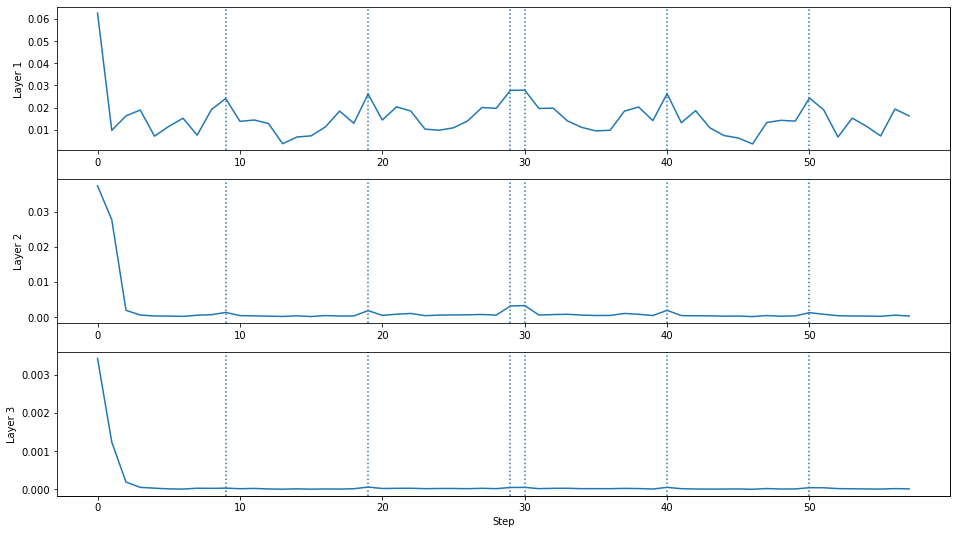

In [41]:
fig = plt.figure()
ax_large = fig.add_subplot(111)

for i, out in enumerate(outs['representation_diff']):
    ax = fig.add_subplot(11 + i + len(outs['representation_diff'])*100)
    ax.plot(np.array(out.cpu()).reshape(59)[1:])
    ax.set_ylabel(f'Layer {i+1}')
    [ax.axes.axvline(b, ls=':') for b in borders]
    if i == len(outs['representation_diff'])-1:
        ax.set_xlabel('Step')
        
ax_large.axes.xaxis.set_ticks([])
ax_large.axes.yaxis.set_ticks([])
gcf = plt.gcf()
gcf.set_size_inches(16,9)